# key point

1. game 'genre' by national area

2. game 'genre'(or others) by years

3. 'high sales game' = 'analysis' and 'visualizing'  


# skill

Sprint 1 : EDA, Feature Engineering, Data Manipulation, Data Visualization

Sprint 2 : Hypothesis Test, CI, Bayesian

Sprint 3 : DR, PCA, Cluster

# Question

Q1. 게임 누적 판매량을 비교하는 것이 적합할까?

-> 만약 2010년에 출시된 액션 장르 게임이 2017년에도 팔리는 것도 여전히 해당 장르 소비자층의 선호도라고 판단합니다.


Q2. 같은 게임이 다른 플랫폼에서 출시된 게임은 데이터가 중복으로 봐야하지 않을까?

-> 본 분석은 어떤 게임장르를 개발하고 어떤 플랫폼을 통해 유통할 것인지를 따져본다.

-> 따라서 동일한 게임이 다른 플랫폼에서 여러번 출시된 경우도 이를 별개의 게임으로 봅니다.

-> 이렇게 해도 데이터의 왜곡은 심하지 않아 장르 선호도를 시간과 지역별로 분석하는데 지장이 없다고 판단합니다.


# Part 1. EDA

point_1 : 발매년도를 사용할 수 없는 게임데이터 삭제

point_2 : 장르와 기타 데이터가 누락된 게임데이터 삭제

point_3 : 판매량 단위를 1만(10K) 단위로 통일

In [19]:
# dataframe package

import pandas as pd
import numpy as np

# visualizing package
import seaborn as sns
import matplotlib.pyplot as plt

# statistic package
import scipy as sp

# load data
url = 'https://raw.githubusercontent.com/laprass/drive/main/vgames2.csv'
game = pd.read_csv(url).drop(['Unnamed: 0'],axis=1)
game.columns = ['name','platform','year','genre','publisher','na','eu','jp','etc'] # columns rename

# pd.set_option('display.max_rows', None)

In [20]:
# check data type = all string!
game.dtypes

name         object
platform     object
year         object
genre        object
publisher    object
na           object
eu           object
jp           object
etc          object
dtype: object

In [21]:
# create def for converting numeric data
## link : https://stackoverflow.com/a/41028390
def value_to_float(x):
    try : 
        if 'K' in x:
            return float(x.replace('K', '')) / 10
        elif 'M' in x:
            return float(x.replace('M', '')) * 100
        elif 'B' in x:
            return float(x.replace('B', '')) * 1000000
        else :
            return float(x) *100
    except :
        return float(x) * 100

In [22]:
# EDA for sales data
game['na'] = game['na'].apply(value_to_float)
game['eu'] = game['eu'].apply(value_to_float)
game['jp'] = game['jp'].apply(value_to_float)
game['etc'] = game['etc'].apply(value_to_float)

In [23]:
# EDA for etc
## removing 'NaN'
game = game.dropna(axis=0, subset=['year','genre','publisher','etc'])

# check
game.isnull().sum()

name         0
platform     0
year         0
genre        0
publisher    0
na           0
eu           0
jp           0
etc          0
dtype: int64

In [24]:
## string to int for year
game['year'] = game['year'].astype(int)
#game.dtypes

In [25]:
## removing not trash year (1979 < & < 2017)
## link : https://leedakyeong.tistory.com/entry/Python-Pandas-Tutorial-Drop-row-or-column-in-pandas-DataFrame
game = game[game.year < 2017]
game = game[game.year > 1979]

## sort ascending by year
game = game.sort_values(by='year')
game.head()

,name,platform,year,genre,publisher,na,eu,jp,etc
15012,Missile Command,2600,1980,Shooter,Atari,256.0,17.0,0.0,3.0
5723,Asteroids,2600,1980,Shooter,Atari,400.0,26.0,0.0,5.0
13133,Freeway,2600,1980,Action,Activision,32.0,2.0,0.0,0.0
5938,Kaboom!,2600,1980,Misc,Activision,107.0,7.0,0.0,1.0
9226,Bridge,2600,1980,Misc,Activision,25.0,2.0,0.0,0.0


# Part 2. Stats analysis

## Step1. Genre  preference by area 

In [26]:
# create genre/area dataset
area_genre = game[['genre','na','eu','jp','etc']].reset_index().drop(['index'],axis=1)
area_genre.head()

,genre,na,eu,jp,etc
0,Shooter,256.0,17.0,0.0,3.0
1,Shooter,400.0,26.0,0.0,5.0
2,Action,32.0,2.0,0.0,0.0
3,Misc,107.0,7.0,0.0,1.0
4,Misc,25.0,2.0,0.0,0.0


In [27]:
# grouping sales data by genre
area_genre = area_genre.groupby(area_genre['genre']).sum()
area_genre

,na,eu,jp,etc
genre,,,,
Action,85596.0,51252.0,15572.0,18364.0
Adventure,10133.0,6332.0,5167.0,1664.0
Fighting,22011.0,9972.0,8639.0,3610.0
Misc,39429.0,20768.0,10371.0,7254.0
Platform,44246.0,19940.0,12922.0,5115.0
Puzzle,12100.0,5039.0,5619.0,1239.0
Racing,35357.0,23420.0,5542.0,7623.0
Role-Playing,30708.0,17631.0,33621.0,5471.0
Shooter,57089.0,30726.0,3734.0,10082.0


In [28]:
# validity check by 'Chi2 Analysis'
## Ho : not difference
## H1 : difference genre with area

from scipy import stats
result_ag = stats.chi2_contingency(area_genre)
print('P ={}, 만약 0.05 이하라면 지역과 장르 간에 차이가 있다고 볼 수 있습니다.'.format(round(result_ag[1],3)))

P =0.0, 만약 0.05 이하라면 지역과 장르 간에 차이가 있다고 볼 수 있습니다.


array([<AxesSubplot:ylabel='na'>, <AxesSubplot:ylabel='eu'>,
       <AxesSubplot:ylabel='jp'>, <AxesSubplot:ylabel='etc'>],
      dtype=object)

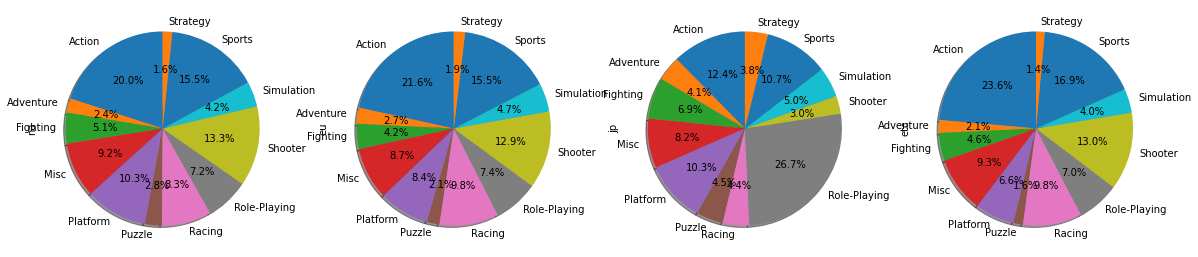

In [29]:
# all year analysis
## https://kontext.tech/column/code-snippets/402/pandas-dataframe-plot-pie-chart
area_genre.groupby(['genre']).sum().plot(kind='pie', subplots=True, shadow = True,startangle=90,
                                         figsize=(20,20), autopct='%1.1f%%', legend = False)

## Step2. Genre preference by time

In [30]:
# # grouping year and genre
# time_na = time_na.groupby(['year','genre']).size()

# # converting series to 'dataframe'
# time_na = time_na.to_frame()
# time_na.head()

# extract df to excel
# link_1 : https://hogni.tistory.com/19
# link_2 : https://ponyozzang.tistory.com/619
# import openpyxl
# game.to_excel('inventors.xlsx')

In [31]:
# North America
time_na = game[['year','genre','na']].reset_index().drop(['index'],axis=1)
time_na = time_na.groupby(['year','genre']).sum() # year -> genre -> amount.sum

# unstack ★★★
## link : https://rfriend.tistory.com/276
time_na_unstack = time_na.unstack().fillna(0).reset_index()

# rename
time_na_unstack.columns = ['year','Action','Adventure',
                           'Fighting','Misc','Platform','Puzzle','Racing',
                           'Role-Playing','Shooter','Simulation','Sports','Strategy']

# set index = year
time_na_unstack = time_na_unstack.set_index('year')

# accumalation
## link : https://www.javaer101.com/ko/article/1786924.html
time_na_unstack = time_na_unstack.cumsum()
time_na_unstack

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
year,,,,,,,,,,,,
1980,32.0,0.0,72.0,253.0,0.0,0.0,0.0,0.0,656.0,0.0,0.0,0.0
1981,1418.0,0.0,72.0,253.0,647.0,209.0,45.0,0.0,1593.0,42.0,74.0,0.0
1982,2025.0,0.0,72.0,334.0,1116.0,1144.0,192.0,0.0,1948.0,42.0,172.0,0.0
1983,2292.0,38.0,72.0,335.0,1396.0,1216.0,192.0,0.0,1993.0,42.0,245.0,0.0
1984,2372.0,38.0,72.0,335.0,1396.0,1285.0,422.0,0.0,4772.0,42.0,415.0,0.0
1985,2536.0,38.0,72.0,335.0,4389.0,1418.0,422.0,0.0,4837.0,42.0,433.0,0.0
1986,3188.0,38.0,72.0,335.0,4496.0,1418.0,535.0,49.0,4931.0,42.0,668.0,0.0
1987,3292.0,257.0,352.0,335.0,4586.0,1418.0,535.0,96.0,4997.0,42.0,708.0,0.0
1988,3407.0,257.0,352.0,335.0,6220.0,1715.0,682.0,106.0,5044.0,42.0,845.0,0.0


<AxesSubplot:xlabel='year'>

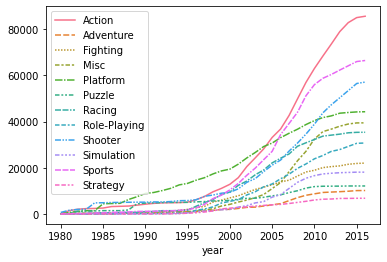

In [32]:
sns.lineplot(data = time_na_unstack)

<AxesSubplot:xlabel='year'>

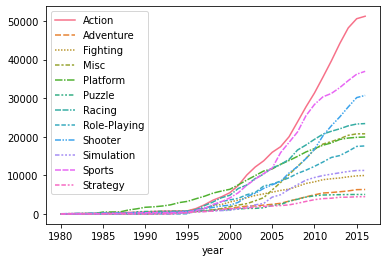

In [33]:
# Euro
time_eu = game[['year','genre','eu']].reset_index().drop(['index'],axis=1)
time_eu = time_eu.groupby(['year','genre']).sum() # year -> genre -> amount.sum

# unstack ★★★
## link : https://rfriend.tistory.com/276
time_eu_unstack = time_eu.unstack().fillna(0).reset_index()

# rename
time_eu_unstack.columns = ['year','Action','Adventure',
                           'Fighting','Misc','Platform','Puzzle','Racing',
                           'Role-Playing','Shooter','Simulation','Sports','Strategy']

# set index = year
time_eu_unstack = time_eu_unstack.set_index('year')

# accumalation
time_eu_unstack = time_eu_unstack.cumsum()
time_eu_unstack

sns.lineplot(data = time_eu_unstack)

<AxesSubplot:xlabel='year'>

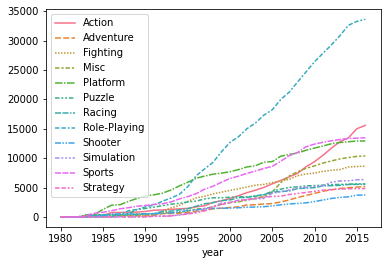

In [34]:
# Japan
time_jp = game[['year','genre','jp']].reset_index().drop(['index'],axis=1)
time_jp = time_jp.groupby(['year','genre']).sum() # year -> genre -> amount.sum

# unstack ★★★
## link : https://rfriend.tistory.com/276
time_jp_unstack = time_jp.unstack().fillna(0).reset_index()

# rename
time_jp_unstack.columns = ['year','Action','Adventure',
                           'Fighting','Misc','Platform','Puzzle','Racing',
                           'Role-Playing','Shooter','Simulation','Sports','Strategy']

# set index = year
time_jp_unstack = time_jp_unstack.set_index('year')

# accumalation
time_jp_unstack = time_jp_unstack.cumsum()
time_jp_unstack

sns.lineplot(data = time_jp_unstack)

<AxesSubplot:xlabel='year'>

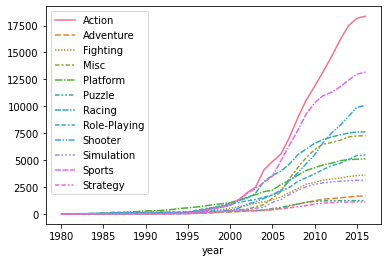

In [35]:
# Other
time_etc = game[['year','genre','etc']].reset_index().drop(['index'],axis=1)
time_etc = time_etc.groupby(['year','genre']).sum() # year -> genre -> amount.sum

# unstack ★★★
## link : https://rfriend.tistory.com/276
time_etc_unstack = time_etc.unstack().fillna(0).reset_index()

# rename
time_etc_unstack.columns = ['year','Action','Adventure',
                           'Fighting','Misc','Platform','Puzzle','Racing',
                           'Role-Playing','Shooter','Simulation','Sports','Strategy']

# set index = year
time_etc_unstack = time_etc_unstack.set_index('year')

# accumalation
time_etc_unstack = time_etc_unstack.cumsum()
time_etc_unstack

sns.lineplot(data = time_etc_unstack)

<AxesSubplot:xlabel='year'>

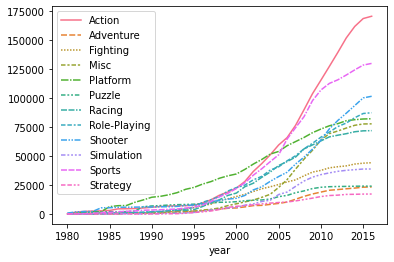

In [40]:
# total
total_game = game.copy()

# total sales
total_game['total'] = total_game['na'] + total_game['eu'] + total_game['jp'] + total_game['etc']

# total dataset
time_total = total_game[['year','genre','total']].reset_index().drop(['index'],axis=1)
time_total = time_total.groupby(['year','genre']).sum() # year -> genre -> amount.sum

# unstack ★★★
## link : https://rfriend.tistory.com/276
time_total_unstack = time_total.unstack().fillna(0).reset_index()

# rename
time_total_unstack.columns = ['year','Action','Adventure',
                           'Fighting','Misc','Platform','Puzzle','Racing',
                           'Role-Playing','Shooter','Simulation','Sports','Strategy']

# set index = year
time_total_unstack = time_total_unstack.set_index('year')

# accumalation
time_total_unstack = time_total_unstack.cumsum()
time_total_unstack


sns.lineplot(data = time_total_unstack)

## Step 3. Publisher Market Shares by Time 

In [41]:
# publisher
time_pub = total_game[['year','publisher','total']].reset_index().drop(['index'],axis=1)
time_pub = time_pub.groupby(['year','publisher']).sum() # year -> genre -> amount.sum

# unstack ★★★
## link : https://rfriend.tistory.com/276
time_pub_unstack = time_pub.unstack().fillna(0).reset_index() 
time_pub_unstack.columns = time_pub_unstack.columns.map('_'.join) # multi column merge ★★
time_pub_unstack.columns = time_pub_unstack.columns.str.replace('total_','') # removing merge name label

# set index = year
time_pub_unstack  = time_pub_unstack.set_index('year_')

# accumalation
time_pub_unstack  = time_pub_unstack.cumsum()
time_pub_unstack

# removing trash pulbisher 
time_pub_trash = time_pub_unstack.T
time_pub_trash = time_pub_trash[time_pub_trash[2016] > 10000 ]
time_pub_trash =  time_pub_trash.T
time_pub_trash

,Activision,Atari,Capcom,Disney Interactive Studios,Electronic Arts,Konami Digital Entertainment,Microsoft Game Studios,Namco Bandai Games,Nintendo,Sega,Sony Computer Entertainment,Square Enix,THQ,Take-Two Interactive,Ubisoft,Warner Bros. Interactive Entertainment
year_,,,,,,,,,,,,,,,,
1980,253.0,835.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1981,1102.0,1677.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1982,1291.0,3620.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1983,1485.0,3961.0,0.0,0.0,0.0,0.0,0.0,0.0,1096.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,1512.0,3961.0,0.0,0.0,0.0,0.0,0.0,343.0,5651.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1985,1561.0,3961.0,100.0,0.0,0.0,0.0,0.0,489.0,10646.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1561.0,4028.0,631.0,0.0,0.0,499.0,0.0,1017.0,12263.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,1672.0,4111.0,712.0,0.0,0.0,592.0,0.0,1284.0,13458.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,1746.0,4111.0,1006.0,0.0,0.0,592.0,0.0,1527.0,17102.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='year_'>

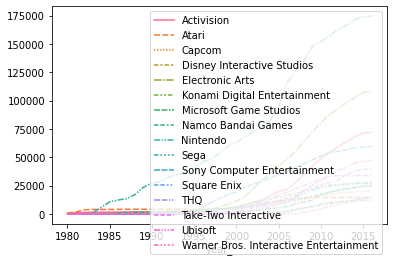

In [42]:
sns.lineplot(data = time_pub_trash)

## Step 4. Platform Market Shares by Time 

<AxesSubplot:xlabel='year_'>

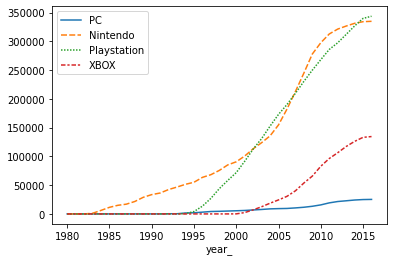

In [43]:
# platform
time_plat = total_game[['year','platform','total']].reset_index().drop(['index'],axis=1)
time_plat = time_plat.groupby(['year','platform']).sum() # year -> genre -> amount.sum

# unstack ★★★
## link : https://rfriend.tistory.com/276
time_plat_unstack = time_plat.unstack().fillna(0).reset_index() 
time_plat_unstack.columns = time_plat_unstack.columns.map('_'.join) # multi column merge ★★
time_plat_unstack.columns = time_plat_unstack.columns.str.replace('total_','') # removing merge name label

# set index = year
time_plat_unstack  = time_plat_unstack.set_index('year_')

# accumalation
time_plat_unstack  = time_plat_unstack.cumsum()
time_plat_unstack

# # removing trash pulbisher 
time_plat_trash = time_plat_unstack.T
time_plat_trash = time_plat_trash[time_plat_trash[2016] > 10000 ]
time_plat_trash =  time_plat_trash.T

# grouping platform
time_plat_trash['Nintendo'] = (time_plat_trash['3DS'] + time_plat_trash['DS'] + time_plat_trash['GB'] +
                          time_plat_trash['SNES'] + time_plat_trash['GBA'] + time_plat_trash['GC'] + 
                          time_plat_trash['N64'] + time_plat_trash['NES'] + time_plat_trash['Wii'])
time_plat_trash = time_plat_trash.drop((['3DS','DS','GB','GBA','GC','N64','NES','SNES','Wii']),axis=1)

time_plat_trash['Playstation'] = (time_plat_trash['PS'] + time_plat_trash['PS2'] + time_plat_trash['PS3'] + 
                                  time_plat_trash['PS4'] + time_plat_trash['PSP'])
time_plat_trash = time_plat_trash.drop((['PS','PS2','PS3','PS4','PSP']),axis=1)

time_plat_trash['XBOX'] = (time_plat_trash['X360'] + time_plat_trash['XB'] + time_plat_trash['XOne'])
time_plat_trash = time_plat_trash.drop((['X360','XB','XOne']),axis=1)
time_plat_trash

sns.lineplot(data = time_plat_trash)

## Step 5. Mega Hit Games (over 10M) Analysis  

In [44]:
# Mega hit games dataset
mega_game = game.copy()

# total sales
mega_game['total'] = mega_game['na'] + mega_game['eu'] + mega_game['jp'] + mega_game['etc']
mega_game = mega_game.sort_values(by='total', ascending = False)

mega_game.head()

,name,platform,year,genre,publisher,na,eu,jp,etc,total
2908,Wii Sports,Wii,2006,Sports,Nintendo,4149.0,2902.0,377.0,846.0,8274.0
4199,Super Mario Bros.,NES,1985,Platform,Nintendo,2908.0,358.0,681.0,77.0,4024.0
12579,Mario Kart Wii,Wii,2008,Racing,Nintendo,1585.0,1288.0,379.0,331.0,3583.0
3352,Wii Sports Resort,Wii,2009,Sports,Nintendo,1575.0,1101.0,328.0,296.0,3300.0
7829,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,1127.0,889.0,1022.0,100.0,3138.0


In [45]:
# nintendo
m1_nintendo = mega_game[mega_game.publisher == 'Nintendo']
print('1-1) 닌텐도의 평균 게임 유통량은 {}만개'.format(round(m1_nintendo['total'].mean())))
print('1-2) 평균 표준편차는 {}만개'.format(round(m1_nintendo['total'].std())))
print('1-3) 흥행게임과 그렇지 않은 게임의 차이가 매우 크다고 할 수 있습니다')

1-1) 닌텐도의 평균 게임 유통량은 253만개
1-2) 평균 표준편차는 566만개
1-3) 흥행게임과 그렇지 않은 게임의 차이가 매우 크다고 할 수 있습니다


In [46]:
# activision
m1_activision = mega_game[mega_game.publisher == 'Activision']
print('1-1) 액티비전의 평균 게임 유통량은 {}만개'.format(round(m1_activision['total'].mean())))
print('1-2) 평균 표준편차는 {}만개'.format(round(m1_activision['total'].std())))
print('1-3) 흥행게임과 그렇지 않은 게임의 차이가 매우 크다고 할 수 있습니다')

1-1) 액티비전의 평균 게임 유통량은 75만개
1-2) 평균 표준편차는 164만개
1-3) 흥행게임과 그렇지 않은 게임의 차이가 매우 크다고 할 수 있습니다


In [47]:
# Electronic Arts-1
m1_ea = mega_game[mega_game.publisher == 'Electronic Arts']
print('1-1) EA의 평균 게임 유통량은 {}만개'.format(round(m1_ea['total'].mean())))
print('1-2) 평균 표준편차는 {}만개'.format(round(m1_ea['total'].std())))
print('1-3) 흥행게임과 그렇지 않은 게임의 차이는 크지만 다른 대형 배급사보다 작습니다.')

1-1) EA의 평균 게임 유통량은 82만개
1-2) 평균 표준편차는 106만개
1-3) 흥행게임과 그렇지 않은 게임의 차이는 크지만 다른 대형 배급사보다 작습니다.


In [48]:
# Electronic Arts-2
m1_ea = mega_game[mega_game.publisher == 'Electronic Arts']
print('1-1) EA의 평균 게임 유통량은 {}만개'.format(round(m1_ea['total'].mean())))
print('1-2) 평균 표준편차는 {}만개'.format(round(m1_ea['total'].std())))
print('1-3) 흥행게임과 그렇지 않은 게임의 차이는 크지만 다른 대형 배급사보다 작습니다.')

1-1) EA의 평균 게임 유통량은 82만개
1-2) 평균 표준편차는 106만개
1-3) 흥행게임과 그렇지 않은 게임의 차이는 크지만 다른 대형 배급사보다 작습니다.


In [49]:
# # million seller
# m1_game = mega_game[mega_game.total > 100]

# # sort by acsending (standard value = ascending)
# ## link : https://rfriend.tistory.com/281
# m1_game = m1_game.sort_values(by=['total'], axis=0, ascending = False).reset_index() 
# m1_game = m1_game.drop(['index','na','eu','jp','etc'], axis=1)

# # genre count
# m1_genre_count = m1_game.groupby(['genre','year']).count()
# m1_genre_count = m1_genre_count.drop(['name','platform','publisher'],axis=1).sort_values(by='year', ascending = False)
# m1_genre_count_unstack = m1_genre_count.unstack().fillna(0).reset_index() 

# # removing multiindex ★★★
# # link : https://stackoverflow.com/questions/22233488/pandas-drop-a-level-from-a-multi-level-column-index
# m1_genre_count_unstack.columns = m1_genre_count_unstack.columns.droplevel() 
# m1_genre_count_unstack = m1_genre_count_unstack.T
# new_header2 = m1_genre_count_unstack.iloc[0]
# m1_genre_count_unstack = m1_genre_count_unstack[1:]
# m1_genre_count_unstack.columns = new_header2
# m1_genre_count_unstack = m1_genre_count_unstack.cumsum()
# m1_genre_count_unstack

# # genre market share
# # m1_genre_share = m1_game.groupby(['genre']).sum()
# # m1_genre_share = m1_genre_share.sort_values(by='total', ascending = False)
# # m1_genre_share 

In [50]:
# # publisher
# time_pub = total_game[['year','publisher','total']].reset_index().drop(['index'],axis=1)
# time_pub = time_pub.groupby(['year','publisher']).sum() # year -> genre -> amount.sum

# # unstack ★★★
# ## link : https://rfriend.tistory.com/276
# time_pub_unstack = time_pub.unstack().fillna(0).reset_index() 
# time_pub_unstack.columns = time_pub_unstack.columns.map('_'.join) # multi column merge ★★
# time_pub_unstack.columns = time_pub_unstack.columns.str.replace('total_','') # removing merge name label

# # set index = year
# time_pub_unstack  = time_pub_unstack.set_index('year_')

# # accumalation
# time_pub_unstack  = time_pub_unstack.cumsum()
# time_pub_unstack

# # removing trash pulbisher 
# time_pub_trash = time_pub_unstack.T
# time_pub_trash = time_pub_trash[time_pub_trash[2016] > 10000 ]
# time_pub_trash =  time_pub_trash.T
# time_pub_trash

array([<AxesSubplot:ylabel='total'>], dtype=object)

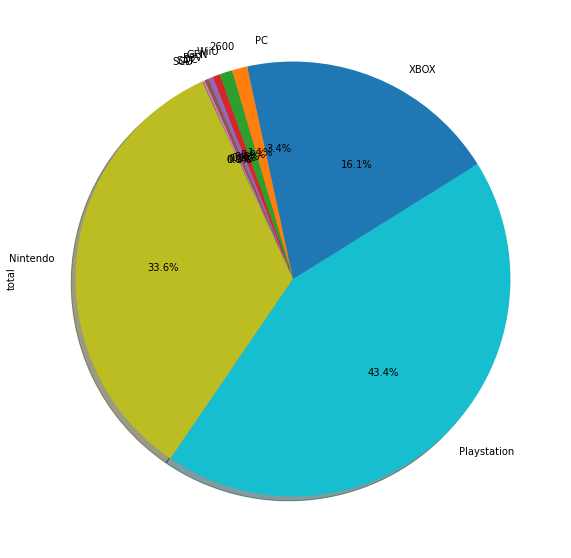

In [51]:
# million seller by platform
m1_game = mega_game[mega_game.total > 100]

# sort by acsending (standard value = ascending)
## link : https://rfriend.tistory.com/281
m1_game = m1_game.sort_values(by=['total'], axis=0, ascending = False).reset_index() 
m1_game = m1_game.drop(['index','na','eu','jp','etc','year'], axis=1)

# plotform count
m1_plat_count = m1_game.groupby(['platform']).count()
m1_plat_count = m1_plat_count.drop(['name','genre','publisher'],axis=1).sort_values(by='total', ascending = False)
m1_plat_count = m1_plat_count.T

m1_plat_count['Nintendo'] = (m1_plat_count['3DS'] + m1_plat_count['DS'] + m1_plat_count['GB'] +
                          m1_plat_count['SNES'] + m1_plat_count['GBA'] + m1_plat_count['GC'] + 
                          m1_plat_count['N64'] + m1_plat_count['NES'] + m1_plat_count['Wii'])
m1_plat_count = m1_plat_count.drop((['3DS','DS','GB','GBA','GC','N64','NES','SNES','Wii']),axis=1)

m1_plat_count['Playstation'] = (m1_plat_count['PS'] + m1_plat_count['PS2'] + m1_plat_count['PS3'] + 
                                  m1_plat_count['PS4'] + m1_plat_count['PSP'])
m1_plat_count = m1_plat_count.drop((['PS','PS2','PS3','PS4','PSP']),axis=1)

m1_plat_count['XBOX'] = (m1_plat_count['X360'] + m1_plat_count['XB'] + m1_plat_count['XOne'])
m1_plat_count = m1_plat_count.drop((['X360','XB','XOne']),axis=1)

m1_plat_count = m1_plat_count.T

m1_plat_count.plot(kind='pie', subplots=True, shadow = True,startangle=90,
                   figsize=(10,10), autopct='%1.1f%%', legend = False)

array([<AxesSubplot:ylabel='total'>], dtype=object)

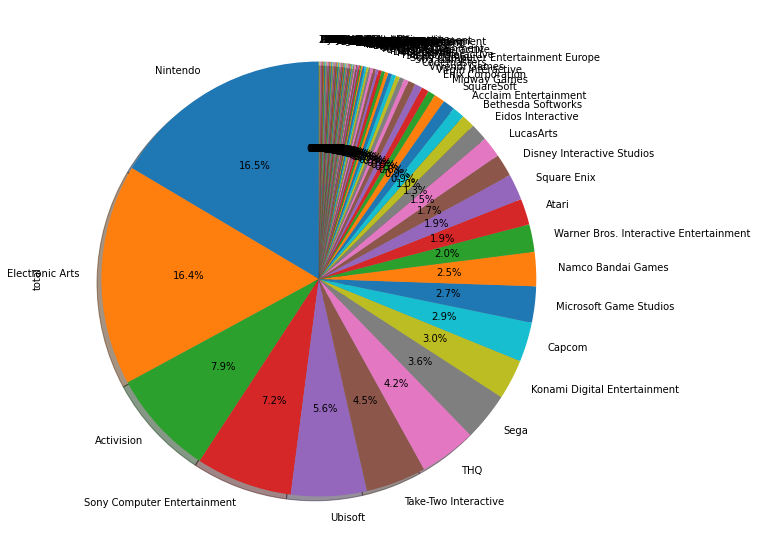

In [52]:
# million seller by publisher
m1_pub_count = m1_game.groupby(['publisher']).count()
m1_pub_count = m1_pub_count.drop(['name','genre','platform'],axis=1).sort_values(by='total', ascending = False)
m1_pub_count.plot(kind='pie', subplots=True, shadow = True,startangle=90,
                  figsize=(10,10), autopct='%1.1f%%', legend = False)

In [94]:
nintendo = total_game[total_game.publisher == 'Nintendo']
nintendo_million = nintendo[nintendo.total > 100] 
nintendo_ratio = nintendo_million[nintendo_million.genre == 'Action'].count()
nintendo_hit = nintendo_ratio[1] / 330

import openpyxl
ea.to_excel('ea.xlsx')

In [79]:
ea = total_game[total_game.publisher == 'Electronic Arts']
ea_million = ea[ea.total > 100] 
ea_ratio = ea_million[ea_million.genre == 'Action'].count()
ea_hit = ea_ratio[1] / 330
ea_hit

0.09696969696969697

In [93]:
# keword filttering
# https://stackoverflow.com/questions/27975069/how-to-filter-rows-containing-a-string-pattern-from-a-pandas-dataframe

nin_1 = nintendo[nintendo['name'].str.contains('Kirby')].count()
nin_2 = nintendo[nintendo['name'].str.contains('Mario')].count()
nin_3 = nintendo[nintendo['name'].str.contains('Yoshi')].count()
nin_4 = nintendo[nintendo['name'].str.contains('Pokemon')].count()
nin_5 = nintendo[nintendo['name'].str.contains('Donkey')].count()
nin_6 = nintendo[nintendo['name'].str.contains('Wii')].count()
nin_7 = nintendo[nintendo['name'].str.contains('Nintendo')].count()
nin_1+nin_2+nin_3+nin_4+nin_5+nin_6+nin_7

name         233
platform     233
year         233
genre        233
publisher    233
na           233
eu           233
jp           233
etc          233
total        233
dtype: int64

In [83]:
104 + 33 + 24 + 26

187

In [ ]:
,'mario','yoshi','pokemon'